In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from genealogy_aligner import Pedigree
from genealogy_aligner.Traversal import Traversal
from genealogy_aligner.Genealogical import Genealogical
import msprime as msp
import matplotlib.pyplot as plt
from genealogy_aligner.ConstraintSatisfaction import backtrack, arc_consistency
from IPython.display import SVG, display
import copy
%run ./LoopyBP.ipynb

In [62]:
np.random.seed(724)

families = 2
generations = 1
avg_children = 2
mat = Pedigree.simulate_from_founders_with_sex(families, generations, avg_children)
pat = copy.deepcopy(mat)

h_graph = mat.get_haplotype_graph()

path = h_graph.sample_path()
tree = path.to_coalescent_tree()

Text(0.5, 1.0, 'Coalescent tree (diploid)')

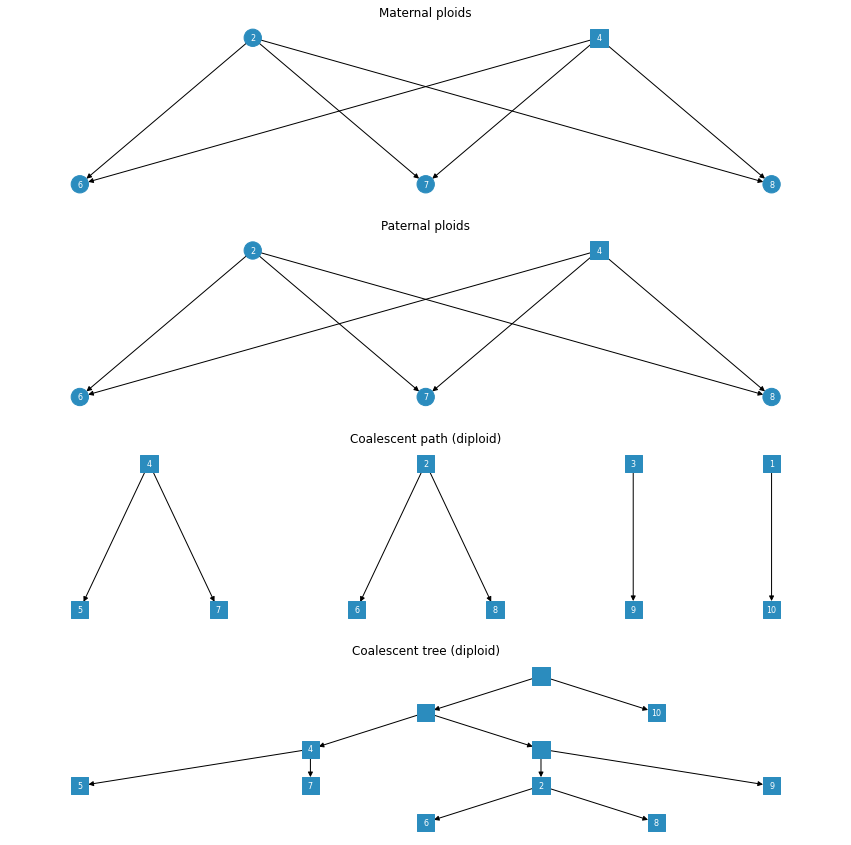

In [63]:
fig, ax = plt.subplots(nrows=4, figsize=(15, 15))

mat.draw(ax=ax[0])
ax[0].set_title('Maternal ploids')
mat.draw(ax=ax[1])
ax[1].set_title('Paternal ploids')
path.draw(ax=ax[2], label_dict=path.ts_node_to_ped_node)
ax[2].set_title('Coalescent path (diploid)')
tree.draw(ax=ax[3], label_dict=tree.ts_node_to_ped_node)
ax[3].set_title('Coalescent tree (diploid)')

In [33]:
edge_labels = {}
c = 1
for u,v in tree.edges:
    edge_labels[(u,v)] = c
    c = c+1
edges = list(edge_labels.values())
edges.append(-1) #corresponding to the value of x

In [34]:
coal_edge = {}
for node in tree.nodes:
    if (node not in tree.probands()):
        for succ in tree.successors(node):
            for pred in tree.predecessors(node):
                coal_edge[edge_labels[(node,succ)]]=edge_labels[(pred,node)]

In [35]:
variables = []
for n in mat.nodes:
    variables.append(str(n)+'m')
for n in pat.nodes:
    variables.append(str(n)+'p')

In [36]:
blue_e = {}
green_e = {}
yellow_e = {}
purple_e = {}
red_e = {}
#Adding auxiliary variables
for mn in mat.nodes:
    par = mat.get_parents(mn)
    #if we are observing inheritance between m alleles and mothers
    if mat.get_node_attributes('sex', par[0]) == 2 or mat.get_node_attributes('sex', par[1]) == 2:
        variables.append('iM'+str(mn)+'m')
        variables.append('iP'+str(mn)+'m')
        #Adding "red" constraints
        red_e[('iM'+str(mn)+'m','iP'+str(mn)+'m')]=0
        
        variables.append('bM'+str(mn)+'m')
        variables.append('bP'+str(mn)+'m')
        #Adding "green" constraints
        green_e[('iM'+str(mn)+'m',str(mn)+'m','bM'+str(mn)+'m')] = 0
        green_e[('iP'+str(mn)+'m',str(mn)+'m','bP'+str(mn)+'m')] = 0
        if mat.get_node_attributes('sex', par[0]) == 2:
            variables.append('N'+str(par[0])+'m')
            variables.append('N'+str(par[0])+'p')
            #Adding "blue" constraints
            blue_e[('N'+str(par[0])+'m', str(par[0])+'m')] = 0
            blue_e[('N'+str(par[0])+'p', str(par[0])+'p')] = 0
            #Adding "yellow" constraints
            yellow_e[('iM'+str(mn)+'m',str(par[0])+'m',str(mn)+'m')] = 0
            yellow_e[('iP'+str(mn)+'m',str(par[0])+'p',str(mn)+'m')] = 0        
        else:
            variables.append('N'+str(par[1])+'m')
            variables.append('N'+str(par[1])+'p')
            #Adding "blue" constraints
            blue_e[('N'+str(par[1])+'m', str(par[1])+'m')] = 0
            blue_e[('N'+str(par[1])+'p', str(par[1])+'p')] = 0
            #Adding "yellow" constraints            
            yellow_e[('iM'+str(mn)+'m',str(par[1])+'m',str(mn)+'m')] = 0
            yellow_e[('iP'+str(mn)+'m',str(par[1])+'p',str(mn)+'m')] = 0

for pn in pat.nodes:
    par = pat.get_parents(pn)
    #if we are observing inheritance between m alleles and mothers
    if pat.get_node_attributes('sex', par[0]) == 1 or pat.get_node_attributes('sex', par[1]) == 1:
        variables.append('iM'+str(mn)+'p')
        variables.append('iP'+str(mn)+'p')
        #Adding "red" constraints
        red_e[('iM'+str(mn)+'p','iP'+str(mn)+'p')]=0
        variables.append('bM'+str(mn)+'p')
        variables.append('bP'+str(mn)+'p')
        #Adding "green" constraints
        green_e[('iM'+str(mn)+'p',str(mn)+'p','bM'+str(mn)+'p')] = 0
        green_e[('iP'+str(mn)+'p',str(mn)+'p','bP'+str(mn)+'p')] = 0
        if mat.get_node_attributes('sex', par[0]) == 1:
            variables.append('N'+str(par[0])+'m')
            variables.append('N'+str(par[0])+'p')
            #Adding "blue" constraints
            blue_e[('N'+str(par[0])+'m', str(par[0])+'m')] = 0
            blue_e[('N'+str(par[0])+'p', str(par[0])+'p')] = 0
            #Adding "yellow" constraints
            yellow_e[('iM'+str(mn)+'p',str(par[0])+'m',str(mn)+'p')] = 0
            yellow_e[('iP'+str(mn)+'p',str(par[0])+'p',str(mn)+'p')] = 0        
        else:
            variables.append('N'+str(par[1])+'m')
            variables.append('N'+str(par[1])+'p')
            #Adding "blue" constraints
            blue_e[('N'+str(par[1])+'m', str(par[1])+'m')] = 0
            blue_e[('N'+str(par[1])+'p', str(par[1])+'p')] = 0
            #Adding "yellow" constraints            
            yellow_e[('iM'+str(mn)+'p',str(par[1])+'m',str(mn)+'p')] = 0
            yellow_e[('iP'+str(mn)+'p',str(par[1])+'p',str(mn)+'p')] = 0
variables = list(set(variables))            
for node in mat.nodes:
    if node not in mat.probands():
        if mat.successors(node)!= None:
            t = mat.successors(node)
            s = mat.successors(node)
            for i in range(len(t)):
                t[i]='b'+str(t[i])+'m'
                s[i]='b'+str(s[i])+'p'
            t.append('N'+str(node)+'m')
            s.append('N'+str(node)+'p')
            #Adding "purple" constraints
            purple_e[tuple(t)] = 0
            purple_e[tuple(s)] = 0

In [37]:
string = ""
c = 1 
l = []
for col in [yellow_e,red_e,green_e,purple_e,blue_e]:
    for k in col.keys():
        col[k]='f'+str(c)
        c = c+1
    for key,value in col.items():
        string = string+value
        string = string + '('
        s = ','.join(key)
        string = string + s
        string = string + ')'
    l.append(c-1)
print(string)

f1(iM6m,2m,6m)f2(iP6m,2p,6m)f3(iM7m,2m,7m)f4(iP7m,2p,7m)f5(iM8m,2m,8m)f6(iP8m,2p,8m)f7(iM8p,4m,8p)f8(iP8p,4p,8p)f9(iM6m,iP6m)f10(iM7m,iP7m)f11(iM8m,iP8m)f12(iM8p,iP8p)f13(iM6m,6m,bM6m)f14(iP6m,6m,bP6m)f15(iM7m,7m,bM7m)f16(iP7m,7m,bP7m)f17(iM8m,8m,bM8m)f18(iP8m,8m,bP8m)f19(iM8p,8p,bM8p)f20(iP8p,8p,bP8p)f21(b6m,b7m,b8m,N2m)f22(b6p,b7p,b8p,N2p)f23(b6m,b7m,b8m,N4m)f24(b6p,b7p,b8p,N4p)f25(N2m,2m)f26(N2p,2p)f27(N4m,4m)f28(N4p,4p)


In [38]:
mrf = string2factor_graph(string)
import pyvis.network as net

In [39]:
def plot_factor_graph(x):
    graph = net.Network(notebook=True, width="100%")
    graph.toggle_physics(False)
    
    # Vertices
    label = x.get_graph().vs['name']
    color = ['#2E2E2E' if i is True else '#F2F2F2' for i in x.get_graph().vs['is_factor']]
    graph.add_nodes(range(len(x.get_graph().vs)), label=label, color=color)
    
    # Edges
    graph.add_edges(x.get_graph().get_edgelist())
    
    return graph.show("graph.html")

In [41]:
#Yellow factor graph
indexlist = []
for e1 in [0,1]:
    for e2 in edges:
        indexlist.append((e1,e2))
yellow = pd.DataFrame(0, index=indexlist, columns=edges)
for e in edge_labels.values():
    for k in edge_labels.values():
        yellow[e].loc[[(0, k)]] = 1
for e in edge_labels.values():
    yellow[e].loc[[(1, e)]] = 1
    yellow[e].loc[[(0, e)]] = 0
for c in coal_edge.keys():
    yellow[coal_edge[c]].loc[[(1,c)]] = 1
    yellow[coal_edge[c]].loc[[(0,c)]] = 0
for e in edges:
    yellow[e].loc[[(1,-1)]] = 1

print(yellow)
yellow = yellow.to_numpy()
yellow = np.array(np.array_split(yellow,2))
print(yellow)
len(yellow.shape)

          1    2    3    4    5    6    7    8    9    10  -1 
(0, 1)     0    1    1    1    1    1    1    0    1    1    0
(0, 2)     1    0    1    1    1    1    1    0    1    1    0
(0, 3)     1    1    0    1    0    1    1    1    1    1    0
(0, 4)     1    1    1    0    0    1    1    1    1    1    0
(0, 5)     1    1    1    1    0    1    0    1    1    1    0
(0, 6)     1    1    1    1    1    0    0    1    1    1    0
(0, 7)     1    1    1    1    1    1    0    1    1    0    0
(0, 8)     1    1    1    1    1    1    1    0    1    0    0
(0, 9)     1    1    1    1    1    1    1    1    0    1    0
(0, 10)    1    1    1    1    1    1    1    1    1    0    0
(0, -1)    0    0    0    0    0    0    0    0    0    0    0
(1, 1)     1    0    0    0    0    0    0    1    0    0    0
(1, 2)     0    1    0    0    0    0    0    1    0    0    0
(1, 3)     0    0    1    0    1    0    0    0    0    0    0
(1, 4)     0    0    0    1    1    0    0    0    0   

3

In [72]:
#Red factor graph
red = pd.DataFrame(0, index=[0,1], columns=[0,1])
red.iloc[0][1]=1
red.iloc[1][0]=1
red = red.to_numpy()

In [73]:
#Green factor graph
indexlist=[]
for e1 in [0,1]:
    for e2 in edges:
        indexlist.append((e1,e2))
green = pd.DataFrame(0, index=indexlist, columns=[0,1])
for e in edge_labels.values():
    green[1].loc[[(1,e)]]=1
green = green.to_numpy()
green = np.array(np.array_split(green,2))
green

array([[[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 0]]])

In [71]:
#Purple factor graph
import itertools
def purple(size):
    pcol = []
    result = [",".join(item) for item in itertools.product("01", repeat=size)]
    for i in range(size+1):
        pcol.append(i)
    purple = pd.DataFrame(0, index=result, columns=pcol)
    for i in purple.index:
        purple[i.count('1')].loc[i]=1
    purple = purple.to_numpy()
    t = tuple()
    for i in range(size):
        t = t+(2,)
    t = t+(size,)
    purple = np.resize(purple, t) 
    return purple
purple(3)

array([[[[1, 0, 0],
         [0, 0, 1]],

        [[0, 0, 0],
         [1, 0, 0]]],


       [[[0, 0, 1],
         [0, 0, 1]],

        [[0, 0, 0],
         [0, 1, 0]]]])

In [74]:
#Blue factor graph
def blue(size):
    bcol = []
    for i in range(size+1):
        bcol.append(i)
    blue = pd.DataFrame(0, index=bcol, columns=edges)
    blue.iloc[0][-1]=1
    for e in edge_labels.values():
        blue[e].loc[1]=1
    for c in coal_edge.keys():
        blue[coal_edge[c]].loc[2] = 1
    return(blue.to_numpy())
blue(3)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [75]:
yellow_inv = {v: k for k, v in yellow_e.items()}
for k in yellow_inv.keys():
    yellow_inv[k]=factor(list(yellow_inv[k]),yellow)
red_inv = {v: k for k, v in red_e.items()}
for k in red_inv.keys():
    red_inv[k]=factor(list(red_inv[k]),red)

green_inv = {v: k for k, v in green_e.items()}
for k in green_inv.keys():
    green_inv[k]=factor(list(green_inv[k]),green)

In [76]:
purple_inv = {v: k for k, v in purple_e.items()}
blue_inv = {v: k for k, v in blue_e.items()}
blue_cp = copy.deepcopy(blue_inv)
for k in blue_inv.keys():
    for j in purple_inv.keys():
        if blue_cp[k][0]==purple_inv[j][-1]:
            blueobj = blue(len(purple_inv[j])-1)
            blue_inv[k]=factor(list(blue_cp[k]),blueobj)

In [77]:
purple_inv = {v: k for k, v in purple_e.items()}
for k in purple_inv.keys():
    purpleobj = purple(len(purple_inv[k])-1)
    purple_inv[k]=factor(list(purple_inv[k]),purpleobj)

In [78]:
factors = []
for k in yellow_inv.keys():
    mrf.change_factor_distribution(k, yellow_inv[k])
    factors.append(yellow_inv[k])
for k in red_inv.keys():
    mrf.change_factor_distribution(k, red_inv[k])
    factors.append(red_inv[k])
for k in green_inv.keys():
    mrf.change_factor_distribution(k, green_inv[k])
    factors.append(green_inv[k])
for k in purple_inv.keys():
    mrf.change_factor_distribution(k, purple_inv[k])
    factors.append(purple_inv[k])

In [79]:
exact = factor_marginalization(joint_distribution([factors[6],factors[18],factors[11],factors[7],factors[19]]), ['4m', '4p','iP8p','iM8p','bP8p','bM8p']).get_distribution()

In [80]:
lbp = loopy_belief_propagation(mrf)